# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

In [1]:
#!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
#!tar -xvf VOCtrainval_11-May-2012.tar

For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

In [14]:
torch.manual_seed(999)

In [1]:
import numpy as np
from PIL import Image


_errstr = "Mode is unknown or incompatible with input array shape."


def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).
    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.
    This function is only available if Python Imaging Library (PIL) is installed.
    Parameters
    ----------
    data : ndarray
        PIL image data array.
    cmin : scalar, optional
        Bias scaling of small values. Default is ``data.min()``.
    cmax : scalar, optional
        Bias scaling of large values. Default is ``data.max()``.
    high : scalar, optional
        Scale max value to `high`.  Default is 255.
    low : scalar, optional
        Scale min value to `low`.  Default is 0.
    Returns
    -------
    img_array : uint8 ndarray
        The byte-scaled array.
    Examples
    --------
    >>> from scipy.misc import bytescale
    >>> img = np.array([[ 91.06794177,   3.39058326,  84.4221549 ],
    ...                 [ 73.88003259,  80.91433048,   4.88878881],
    ...                 [ 51.53875334,  34.45808177,  27.5873488 ]])
    >>> bytescale(img)
    array([[255,   0, 236],
           [205, 225,   4],
           [140,  90,  70]], dtype=uint8)
    >>> bytescale(img, high=200, low=100)
    array([[200, 100, 192],
           [180, 188, 102],
           [155, 135, 128]], dtype=uint8)
    >>> bytescale(img, cmin=0, cmax=255)
    array([[91,  3, 84],
           [74, 81,  5],
           [52, 34, 28]], dtype=uint8)
    """
    if data.dtype == np.uint8:
        return data

    if high > 255:
        raise ValueError("`high` should be less than or equal to 255.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint8)


def toimage(arr, high=255, low=0, cmin=None, cmax=None, pal=None,
            mode=None, channel_axis=None):
    """Takes a numpy array and returns a PIL image.
    This function is only available if Python Imaging Library (PIL) is installed.
    The mode of the PIL image depends on the array shape and the `pal` and
    `mode` keywords.
    For 2-D arrays, if `pal` is a valid (N,3) byte-array giving the RGB values
    (from 0 to 255) then ``mode='P'``, otherwise ``mode='L'``, unless mode
    is given as 'F' or 'I' in which case a float and/or integer array is made.
    .. warning::
        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).
    Notes
    -----
    For 3-D arrays, the `channel_axis` argument tells which dimension of the
    array holds the channel data.
    For 3-D arrays if one of the dimensions is 3, the mode is 'RGB'
    by default or 'YCbCr' if selected.
    The numpy array must be either 2 dimensional or 3 dimensional.
    """
    data = np.asarray(arr)
    if np.iscomplexobj(data):
        raise ValueError("Cannot convert a complex-valued array.")
    shape = list(data.shape)
    valid = len(shape) == 2 or ((len(shape) == 3) and
                                ((3 in shape) or (4 in shape)))
    if not valid:
        raise ValueError("'arr' does not have a suitable array shape for "
                         "any mode.")
    if len(shape) == 2:
        shape = (shape[1], shape[0])  # columns show up first
        if mode == 'F':
            data32 = data.astype(np.float32)
            image = Image.frombytes(mode, shape, data32.tostring())
            return image
        if mode in [None, 'L', 'P']:
            bytedata = bytescale(data, high=high, low=low,
                                 cmin=cmin, cmax=cmax)
            image = Image.frombytes('L', shape, bytedata.tostring())
            if pal is not None:
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
                # Becomes a mode='P' automagically.
            elif mode == 'P':  # default gray-scale
                pal = (np.arange(0, 256, 1, dtype=np.uint8)[:, np.newaxis] *
                       np.ones((3,), dtype=np.uint8)[np.newaxis, :])
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
            return image
        if mode == '1':  # high input gives threshold for 1
            bytedata = (data > high)
            image = Image.frombytes('1', shape, bytedata.tostring())
            return image
        if cmin is None:
            cmin = np.amin(np.ravel(data))
        if cmax is None:
            cmax = np.amax(np.ravel(data))
        data = (data*1.0 - cmin)*(high - low)/(cmax - cmin) + low
        if mode == 'I':
            data32 = data.astype(np.uint32)
            image = Image.frombytes(mode, shape, data32.tostring())
        else:
            raise ValueError(_errstr)
        return image

    # if here then 3-d array with a 3 or a 4 in the shape length.
    # Check for 3 in datacube shape --- 'RGB' or 'YCbCr'
    if channel_axis is None:
        if (3 in shape):
            ca = np.flatnonzero(np.asarray(shape) == 3)[0]
        else:
            ca = np.flatnonzero(np.asarray(shape) == 4)
            if len(ca):
                ca = ca[0]
            else:
                raise ValueError("Could not find channel dimension.")
    else:
        ca = channel_axis

    numch = shape[ca]
    if numch not in [3, 4]:
        raise ValueError("Channel axis dimension is not valid.")

    bytedata = bytescale(data, high=high, low=low, cmin=cmin, cmax=cmax)
    if ca == 2:
        strdata = bytedata.tostring()
        shape = (shape[1], shape[0])
    elif ca == 1:
        strdata = np.transpose(bytedata, (0, 2, 1)).tostring()
        shape = (shape[2], shape[0])
    elif ca == 0:
        strdata = np.transpose(bytedata, (1, 2, 0)).tostring()
        shape = (shape[2], shape[1])
    if mode is None:
        if numch == 3:
            mode = 'RGB'
        else:
            mode = 'RGBA'

    if mode not in ['RGB', 'RGBA', 'YCbCr', 'CMYK']:
        raise ValueError(_errstr)

    if mode in ['RGB', 'YCbCr']:
        if numch != 3:
            raise ValueError("Invalid array shape for mode.")
    if mode in ['RGBA', 'CMYK']:
        if numch != 4:
            raise ValueError("Invalid array shape for mode.")

    # Here we know data and mode is correct
    image = Image.frombytes(mode, shape, strdata)
    return image

### 1.1 Loading the dataset

In [1]:
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob

from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms

from torchvision.transforms import ToTensor



class pascalVOCDataset(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        sbd_path=None,
        split="train_aug",
        is_transform=False,
        img_size=256,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        if not self.test_mode:
            for split in ["train", "val", "trainval"]:
                path = pjoin(self.root, "ImageSets/Segmentation", split + ".txt")
                file_list = tuple(open(path, "r"))
                file_list = [id_.rstrip() for id_ in file_list]
                self.files[split] = file_list
            self.setup_annotations()

        self.tf = transforms.Compose(
            [
                # add more trasnformations as you see fit
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
        im = Image.open(im_path)
        #lbl = ToTensor()(Image.open(lbl_path))
        lbl = Image.open(lbl_path)
        
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
            
        #outputFeatures = []

        #for i in range(21):
        #    outputFeatures.append((lbl == i).float())
            
        outputTensor = torch.zeros((21, self.img_size[0], self.img_size[0]), dtype=torch.float32)

        for i in range(21):
            outputTensor[i] = lbl == i
            
        
        return im,outputTensor#torch.stack(outputFeatures)# torch.clamp(lbl, max=20)

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]), Image.NEAREST)
            
        img = self.tf(img)
        lbl = torch.from_numpy(np.array(lbl)).int()
        lbl[lbl == 255] = 0
        return img, lbl
    
    
    @staticmethod
    def get_torch_labels():
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return torch.tensor(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    @staticmethod
    def get_pascal_labels():
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    @staticmethod
    def encode_segmap(mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        
        mask = mask.astype(int)
        mask = mask[:, :, 0:3]
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(pascalVOCDataset.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))] = ii
        label_mask = label_mask.astype(int)
        # print(np.unique(label_mask))
        return label_mask

    @staticmethod
    def decode_segmap(label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_mask = (label_mask * 255).long()
        label_colours = torch.from_numpy(pascalVOCDataset.get_pascal_labels()).to(torch.int16)
        r = torch.zeros(label_mask.shape, dtype=torch.int16)
        g = torch.zeros(label_mask.shape, dtype=torch.int16)
        b = torch.zeros(label_mask.shape, dtype=torch.int16)
        for ll in range(0, 21):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = torch.zeros((3, label_mask.shape[0], label_mask.shape[1]))
        rgb[0, :, :] = r
        rgb[1, :, :] = g
        rgb[2, :, :] = b

        rgb /= 255

        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """Sets up Berkley annotations by adding image indices to the
        `train_aug` split and pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). This
        function also defines the `train_aug` and `train_aug_val` data splits
        according to the description in the class docstring
        """
        sbd_path = self.sbd_path
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["train"]

        # keep unique elements (stable)
        train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
        self.files["train_aug"] = train_aug
        set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected = np.unique(self.files["train_aug"] + self.files["val"]).size

        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")

            for ii in tqdm(self.files["trainval"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = pascalVOCDataset.encode_segmap(imageio.imread(lbl_path))
                lbl = toimage(lbl, high=lbl.max(), low=lbl.min())
                imageio.imsave(pjoin(target_path, fname), lbl)

        assert expected == 2913, "unexpected dataset sizes"

### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [2]:
# Creating an instance of the model defined above. 
# You can modify it incase you need to pass paratemers to the constructor.



### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [3]:
local_path = 'VOCdevkit/VOC2012/' # modify it according to your device
bs = 5
epochs = 10


### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [4]:
# dataset variable
dst = pascalVOCDataset(local_path, is_transform= True)

def wrap(tup):
    a,b = tup
    return (a.unsqueeze(0), b)

# dataloader variable
#trainloader = [wrap(dst[i]) for i in range(len(dst))]



trainloader = data.DataLoader(
        dst,
        batch_size=bs,
        num_workers = 10
        #shuffle=True,
    )

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class layer(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        padding,
    ):
        super(layer, self).__init__()

        self.seq = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                padding=padding,
            ), 
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.seq(x)
    
class layers(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels_list
    ):
        super(layers, self).__init__()

        convolutions = []
        
        for out_channels in out_channels_list:
            convolutions.append(layer(in_channels, out_channels, 3, 1))
            in_channels = out_channels
        
        self.convolutions = nn.Sequential(*convolutions)

    def forward(self, x):
        return self.convolutions(x)

    
class stepDown(nn.Module):
    def __init__(self, in_channels, out_channels, conv_size):
        super(stepDown, self).__init__()
        self.layers = layers(in_channels, [out_channels] * (conv_size) )
        self.maxpool = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, x):
        x = self.layers(x)
        size = x.size()
        x, indices = self.maxpool(x)
        return x, indices, size

class stepUp(nn.Module):
    def __init__(self, in_channels, out_channels, conv_size):
        super(stepUp, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.layers = layers(in_channels, [in_channels] * (conv_size - 1) + [out_channels] )
            
    def forward(self, x, indices, output_size):
        x = self.unpool(input=x, indices=indices, output_size=output_size)
        x = self.layers(x)
        return x



class Segnet(nn.Module):
    def __init__(self, stepSize, downs, ups):
        super(Segnet, self).__init__()
        self.stepSize = stepSize
        self.downs = nn.ModuleList([stepDown(*down) for down in downs])
        self.ups = nn.ModuleList([stepUp(*up) for up in ups])

    def forward(self, x):
        values = [None] * self.stepSize
        for i, down in enumerate(self.downs):
            x, *values[i] = down(x)
            
        
        for i, up in zip(range(self.stepSize - 1, -1, -1), self.ups):
            x = up(x, *values[i])

        return x

### 1.5 Loss fuction and Optimizer(1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [4]:
import torch.optim as optim
import torchvision.models as models

device = torch.device("cuda:0")

downs = [
    (3, 64, 2),
    (64, 128, 2),
    (128, 256, 3),
    (256, 512, 3),
    (512, 512, 3),
]

ups = [
    (512, 512, 3),
    (512, 256, 3),
    (256, 128, 3),
    (128, 64, 2),
    (64, 21, 2),
]

model = Segnet(5, downs, ups).cuda()
#model = Segnet()

model = model.to(device)

#model = model.to(device)

# loss function
criterion = nn.MSELoss()


# optimizer variable
opt = optim.Adam(model.parameters())





def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp


get_n_params(model)

#opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

29455167

### 1.6 Training the model(3.0 points)
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

210 9000


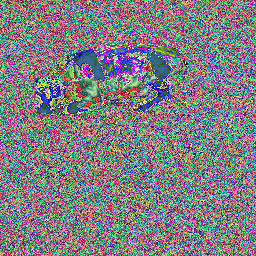

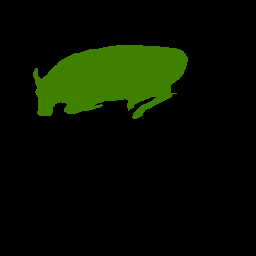

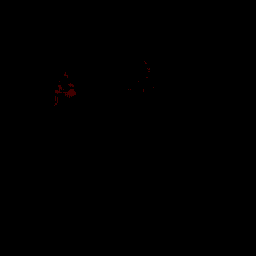

In [11]:
from IPython.display import clear_output
loss = None
count = 0

colors = pascalVOCDataset.get_torch_labels() / 255

#error()
try:
    for _ in range(2000):
        for i, (inputs, targets) in enumerate(trainloader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            opt.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            opt.step()  

            if count % 100 == 0:
                if count % 500 == 0:
                    torch.save(model, "segnetNew.model")
                indices = torch.argmax(outputs.cpu(), 1)
                targetIndices = torch.argmax(targets.cpu(), 1)

                colorImage = torch.stack([colors[indices, 0 ], colors[indices, 1], colors[indices, 2]], dim=1)
                targetImage = torch.stack([colors[targetIndices, 0 ], colors[targetIndices, 1], colors[targetIndices, 2]], dim=1)

                clear_output(wait=False)
                print(i, count)
                display(transforms.ToPILImage()( inputs[0] ))
                display(transforms.ToPILImage()( targetImage[0] ))
                display(transforms.ToPILImage()( colorImage[0] ))
            count+=1

except KeyboardInterrupt:
    torch.save(model, "segnetSaved.model")
         
#error()

### 1.7 Evaluate your model(1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [ ]:
def evaluate(ground_truth, predictions):
    
    return f1_score, auc_score, dice_coeeficient

### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

In [1]:
import torch
torch.cuda.empty_cache() 

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.